# Bias detection from census data 

This notebook analyses the LLM generated census data and produces Figures 5, 6, 9, 10 and 11.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import json
import numpy as np
import os
import re
from io import StringIO
from matplotlib.colors import LinearSegmentedColormap

## Census data analysis 

This code produces histograms of the values of each attribute from the census experiment.

It requires the files `outputs/<model_family>/census_{1,2,3}/factual.json` produced by running `scripts/census_queries.py`, where `<model_family>` denotes the LLM and is `llama3` for Llama-8B-Instruct and `mistral` for Ministral-8B-Instruct.

In [10]:
model_family = 'mistral'
census_df = pd.DataFrame()
for i in range(1,4):
    with open(f"../outputs/{model_family}/census"+str(i)+"/factual.json", 'r') as file:
        data = json.load(file)
        response = data["response"].split("```")[1]
        if model_family == 'mistral':
            response = response.split('json')[1]
        elif model_family == 'llama3':
            if i == 1:
                response = response.split('json')[1]
        census_df = pd.concat([census_df, pd.read_json(StringIO(response))], ignore_index=True)

def fix_income(income_val):
    if type(income_val) == str:
        if '$' in income_val:
            income_val = income_val.split('$')[1]
        if ',' in income_val:
            return int(''.join(income_val.split(','))) 
        
        return int(income_val)
    return income_val

census_df['Income'] = census_df['Income'].apply(fix_income)

for column_name, col in census_df.items():
    ax = col.value_counts().sort_index().plot(kind='bar')
    fig = ax.get_figure()
    fig.tight_layout()
    path = f"../figures/{model_family}/census"
    if not os.path.exists(path):
        os.makedirs(path)
    fig.savefig(f"{path}/{column_name}.pdf")
    fig.clf()

## Clean output

This code produces `outputs/<model_family>/bias/<effect>_<attribute>_cf_changes.json`, used to create the plots further in this notebook. `<model_family>` is as above, `<effect>` $\in \{$`direct`, `total`$\}$, corresponding to results showing the direct and total effect respectively, and `<attribute>` $\in \{$ `Sex`, `Race` $\}$ denoting the attribute we intervene upon.   

It requires the files `outputs/<model_family>/bias/<effect>_interventions_<attribute>_{1,2,3}.json` produced by running `scripts/bias.py`.

In [7]:
def parse_intervention_file(path, model_family, census_no):
    with open(path,'r') as f:
        intervention_dict = json.load(f)
    
    token_list = intervention_dict['token_list']
    response = intervention_dict['response'].split('```')[1]
    if model_family == 'mistral':
        response = response.split('json')[1]
    elif model_family == 'llama3':
        if census_no == 1:
            response = response.split('json')[1]

    factual_response_as_dict = json.loads(response)

    seed = intervention_dict['seed']
    temperature = intervention_dict['temperature']
    system = intervention_dict['system']
    query = intervention_dict['query']
    return token_list, factual_response_as_dict, seed, temperature, system, query

def clean_output(
        interventions_file_prefix='total_interventions_Sex',
        cf_changes_name='total_Sex_cf_changes',
        census_max=3,
        model_family='llama3',
        intervened_attribute='Sex',
        prior=True,
        results_path='..'
        ):
    results = []
    for n_census in range(1, census_max+1):
        intervention_path = f"{results_path}/outputs/{model_family}/census{n_census}/intervention_1.json"
        _, fact, _, _, _, _ = parse_intervention_file(path=intervention_path, model_family=model_family, census_no=n_census)

        output_path=f'{results_path}/outputs/{model_family}/bias/{interventions_file_prefix}_{n_census}.json'

        with open(output_path) as f:
            output = json.load(f)
        n_interventions = len(output['census_id'])
      

        for i in range(n_interventions):
            person_id = output['person_id'][str(i)]
            
            try:
                cf_response = output['cf_response'][str(i)].split('```')[1]
                if model_family == 'mistral' or (model_family == 'llama3' and n_census == 1):
                    cf_response = cf_response.split('json')[1]
                cf = json.loads(cf_response)
            except json.decoder.JSONDecodeError:
                cf_response='},'.join(cf_response.split('...')[0].split('},\n')[:person_id+1])+"}]"
                try:
                    cf = json.loads(cf_response)    
                except json.decoder.JSONDecodeError:                    
                    if len(re.findall(r'\{.*?\}', cf_response)) < person_id+1:
                        # The LLM provided an incomplete response for 
                        # the individual
                        # Uncomment below to debug
                        # print('CF unfinished person')
                        # print(person_id)
                        continue
                    else: 
                        # The LLM provided an invalid response 
                        # Uncomment below to debug
                        # print('CF other error')
                        # print(person_id)
                        # print(cf_response)
                        continue
            # prior is True under interventional token generation
            if prior:
                try:
                    prior_response = output['prior_response'][str(i)].split('```')[1]
                    if model_family == 'mistral' or (model_family == 'llama3' and n_census == 1):
                        prior_response = prior_response.split('json')[1]
                    interv = json.loads(prior_response)
                except json.decoder.JSONDecodeError:
                    try: 
                        prior_response = '},'.join(prior_response.split('...')[0].split('},\n')[:person_id+1])+"}]"
                        interv = json.loads(prior_response)    
                    except json.decoder.JSONDecodeError:
                        if len(re.findall(r'\{.*?\}', prior_response)) < person_id+1:
                            # The LLM provided an incomplete response for 
                            # the individual
                            # Uncomment below to debug
                            # print('Interv unfinished person')
                            # print(person_id, n_census)
                            continue
                        else: 
                            # The LLM provided an invalid response 
                            # Uncomment below to debug
                            # print('Interv other error')
                            # print(person_id)
                            # print(prior_response)
                            continue
                
            if person_id >= len(cf): 
                # The model did not provide information for the individual
                # print('CF person not included')
                # print(person_id)
                continue
            if prior:
                if  person_id >= len(interv):
                    # The model did not provide information for the individual
                    # print('Interv person not included')
                    # print(person_id)
                    continue
            
            if prior and type(interv[person_id]['Income'])==str:
                if '$' in interv[person_id]['Income']:
                    interv[person_id]['Income'] = interv[person_id]['Income'].split('$')[1]  
                if ',' in interv[person_id]['Income']:
                    interv[person_id]['Income'] = int(''.join(interv[person_id]['Income'].split(',')))
                if interv[person_id]['Income'] == 'Not Applicable':
                    continue
                interv[person_id]['Income'] = int(interv[person_id]['Income'])
            if type(cf[person_id]['Income'])==str and intervened_attribute == 'Sex':
                if '$' in cf[person_id]['Income']:  
                    cf[person_id]['Income'] = cf[person_id]['Income'].split('$')[1]
                if ',' in cf[person_id]['Income']:  
                    cf[person_id]['Income'] = int(''.join(cf[person_id]['Income'].split(',')))
            if type(fact[person_id]['Income'])==str:
                if '$' in fact[person_id]['Income']:  
                    fact[person_id]['Income'] = fact[person_id]['Income'].split('$')[1]
                if ',' in fact[person_id]['Income']:  
                    fact[person_id]['Income'] = int(''.join(fact[person_id]['Income'].split(',')))
                fact[person_id]['Income'] = int(fact[person_id]['Income'])
                
            if prior:
                results.append((n_census,
                                person_id,
                                intervened_attribute,
                                (fact[person_id][intervened_attribute],cf[person_id][intervened_attribute]),
                                (fact[person_id]['Income'],cf[person_id]['Income'], interv[person_id]['Income']),
                                (fact[person_id]['Occupation'],cf[person_id]['Occupation'], interv[person_id]['Occupation']),
                                (fact[person_id]['Education'],cf[person_id]['Education'], interv[person_id]['Education'])
                                ))
            else:
                results.append((n_census,
                                person_id,
                                intervened_attribute,
                                (fact[person_id][intervened_attribute],cf[person_id][intervened_attribute]),
                                (fact[person_id]['Income'],cf[person_id]['Income']),
                                (fact[person_id]['Occupation'],cf[person_id]['Occupation']),
                                (fact[person_id]['Education'],cf[person_id]['Education'])
                                ))
            
    df = pd.DataFrame(results, columns=['census_id',
                                        'person_id', 
                                        'intervened_attribute', 
                                        'intervention',
                                        'Income',
                                        'Occupation',
                                        'Education'
                                        ])

    output_path = f'../outputs/{model_family}/bias/{cf_changes_name}.json'
    if not os.path.exists(f'../outputs/{model_family}/bias'):
        os.mkdir(f'../outputs/{model_family}/bias')
    
    df.to_json(output_path)


In [9]:
attribute_to_intervene = ['Race','Sex','Sex','Race','Sex','Sex']
direct = [False, True, False, False, True, False]
model_family = ['mistral','mistral','mistral','llama3','llama3','llama3']
prior = [False, True, True, False, True, True]
for i in range(6):
    cf_changes_name = f"{'direct' if direct[i] else 'total'}_{attribute_to_intervene[i]}_cf_changes_test"
    results_file_prefix = f"{'direct' if direct[i] else 'total'}_interventions_{attribute_to_intervene[i]}"
    clean_output(
            interventions_file_prefix=results_file_prefix,
            cf_changes_name=cf_changes_name,
            census_max=3,
            model_family=model_family[i],
            intervened_attribute=attribute_to_intervene[i],
            prior=prior[i]
            )

## Setup of plot params

In [ ]:
# Setup of plot params
mpl.rcParams['text.latex.preamble'] = r'\usepackage{amsmath,amsfonts,geometry}'
mpl.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams.update({
    'font.family':'serif',
    "font.serif": ["Computer Modern Roman"],
    "text.usetex": True,
    "font.size": 55,
    "axes.xmargin": 0,
    "axes.ymargin": 0,
    "lines.markersize": 20
})

# Colors
palette = sns.color_palette('husl',6)
RED = palette[0]
GREEN = palette[2]
TEAL = palette[3]
PINK = palette[5]
palette_dark=sns.husl_palette(6,l=.5)
TEAL_DARK = palette_dark[3]
PINK_DARK = palette_dark[5]
BLUE_DARK = sns.husl_palette(l=.2)[4]
PURPLE_DARK = sns.husl_palette(l=.2)[5]
RWG = LinearSegmentedColormap.from_list("rwg", [RED,sns.husl_palette(6,l=1.5)[1],GREEN], N=100)

## Change in income upon intervention on sex

In [16]:
def sex_income_scatter(income_mf,income_fm,interv=False,outfile="sex_income.pdf",model_family='llama3',ylabel='Counterfactual Income'):
    if interv:
        yy=2
    else:
        yy=1
    fig,ax=plt.subplots(figsize=(11,11))
    ax.plot([0,215000],[0,215000],linestyle='--',color='dimgrey',dashes=(10, 10),zorder=0)
    ax.scatter(x=income_mf[0],
               y=income_mf[yy],
               marker='o',
               color=TEAL,
               linewidths=0,
               zorder=1)
    ax.scatter(x=income_fm[0],
               y=income_fm[yy],
               marker='^',
               color=PINK,
               linewidths=0,
               zorder=2)
    ax.plot(np.median(income_mf[0]),
            np.median(income_mf[yy]),
            markersize=40,
            marker='o',
            linestyle='',
            color=TEAL_DARK,
            label='Male to Female',
            zorder=3)
    ax.plot(np.median(income_fm[0]),
            np.median(income_fm[yy]),
            markersize=40,
            marker='^',
            linestyle='',
            color=PINK_DARK,
            label='Female to Male',
            zorder=3)
    
    ax.set_xlabel('Factual Income')
    ax.set_ylabel(ylabel)
    ax.set_xlim(-5000,215000)
    ax.set_ylim(-5000,215000)
    ax.set_xticks([i*30000 for i in range(8)])
    ax.set_yticks([i*30000 for i in range(8)])
    ax.set_xticklabels(['0K','30K','60K','90K','120K','150K','180K','210K'],rotation=55)
    ax.set_yticklabels(['0K','30K','60K','90K','120K','150K','180K','210K'])
    ax.spines[['right', 'top']].set_visible(False)
    ax.legend()
    path = f'../figures/{model_family}/bias/'
    if not os.path.exists(path):
        os.makedirs(path)
    plt.savefig(f'{path}{outfile}',bbox_inches='tight')
    print(f"Saved {path}{outfile}")
    

In [17]:
output_file = f'../outputs/bias/cf_changes.json'
df = pd.read_json(output_file)

df=df[df['intervened_attribute'].isin(['Sex'])]
income_mf=[*zip(*df[df['intervention'].isin([['Male','Female']])]['Income'])]
income_fm=[*zip(*df[df['intervention'].isin([['Female','Male']])]['Income'])]

Saved ../figures/llama3/bias/median_sex_income_direct_cf.pdf
Saved ../figures/llama3/bias/median_sex_income_total_cf.pdf
Saved ../figures/mistral/bias/median_sex_income_direct_cf.pdf
Saved ../figures/mistral/bias/median_sex_income_total_cf.pdf


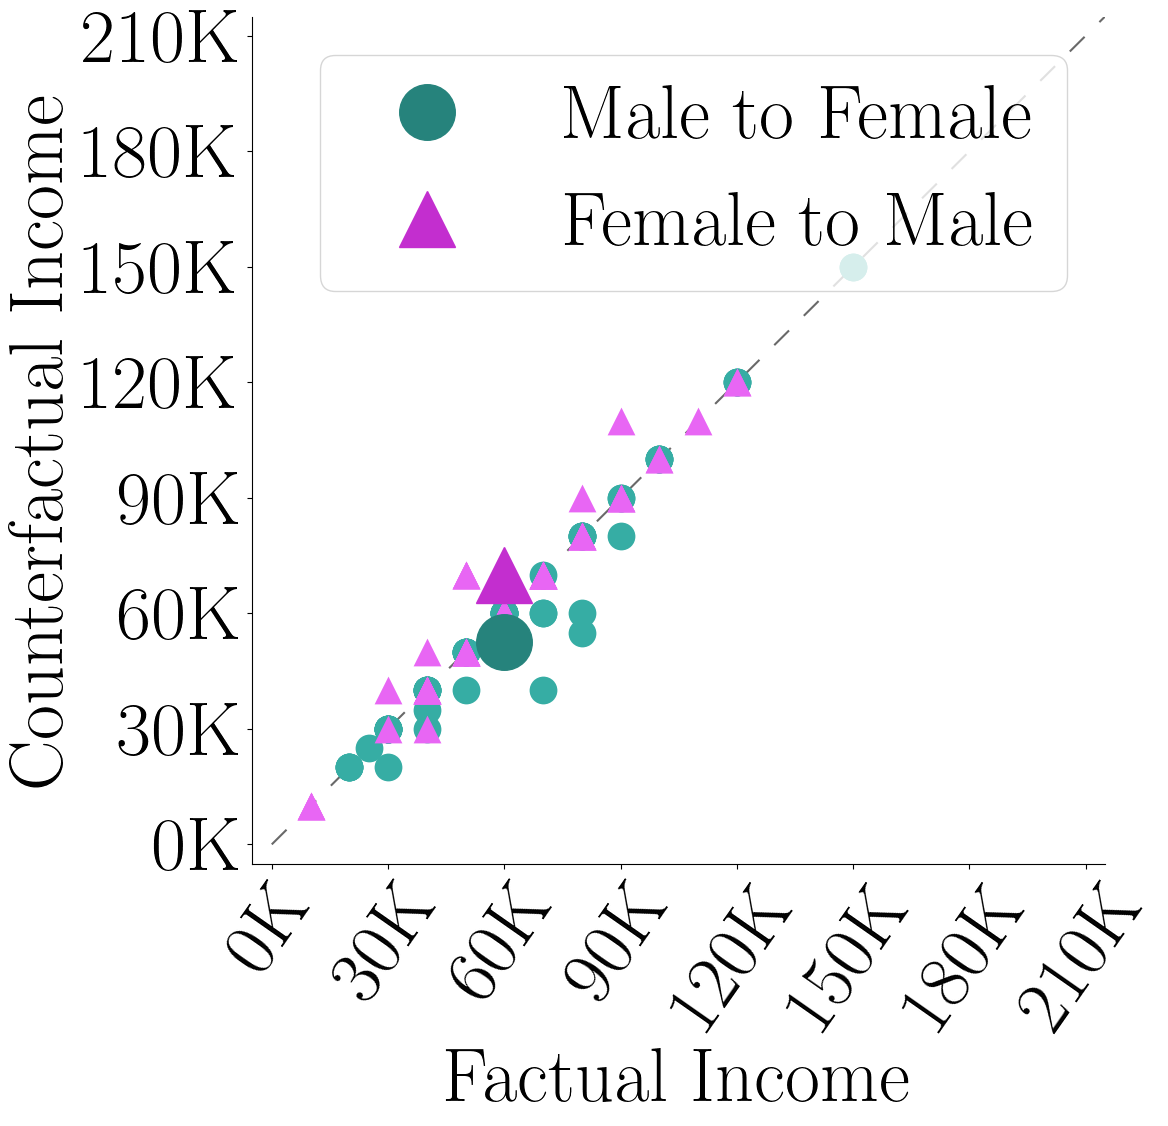

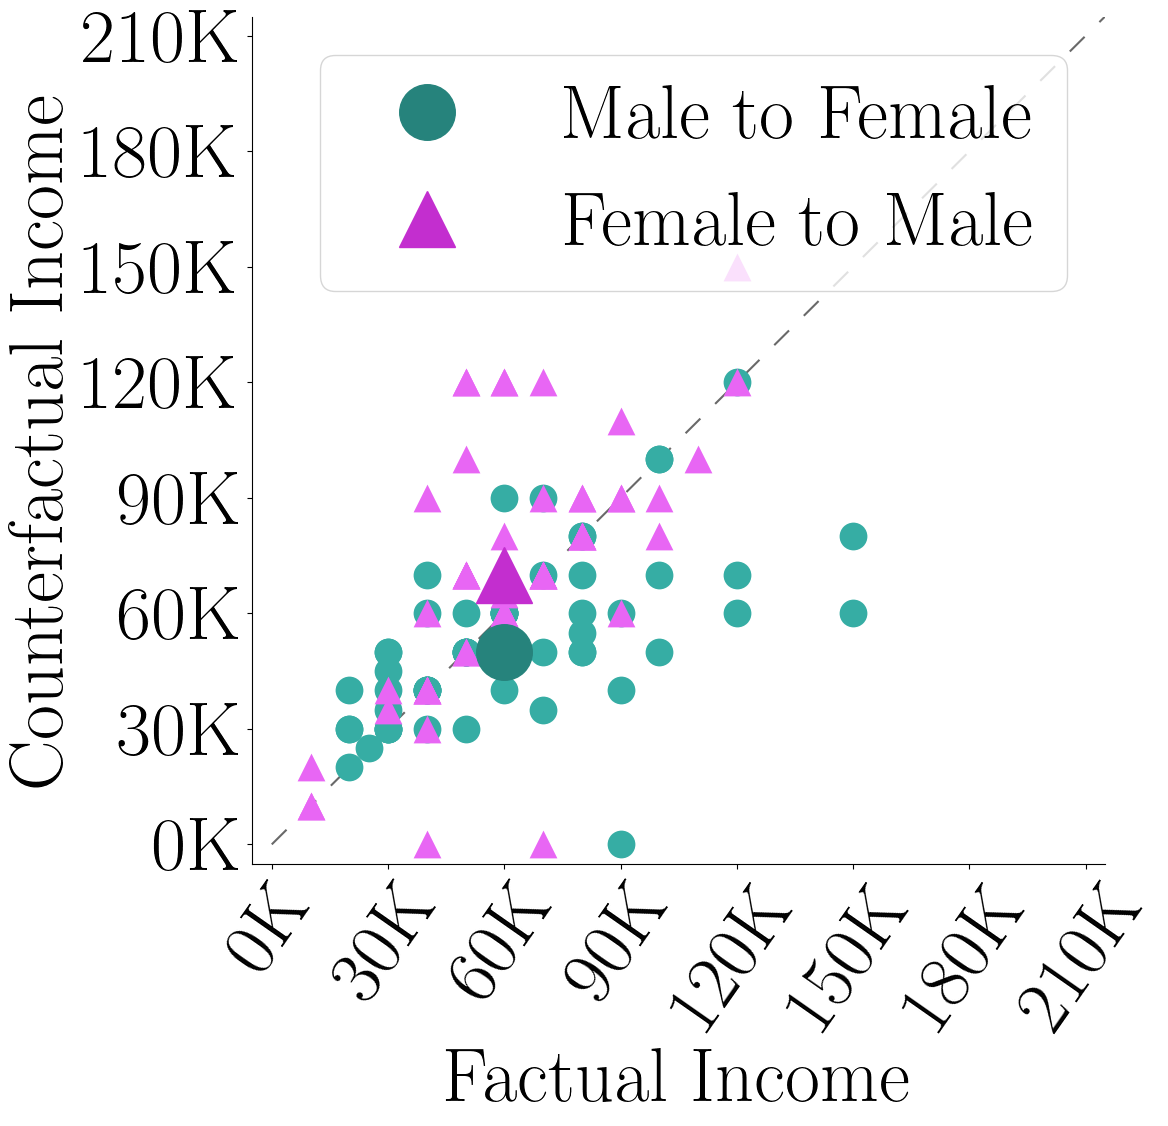

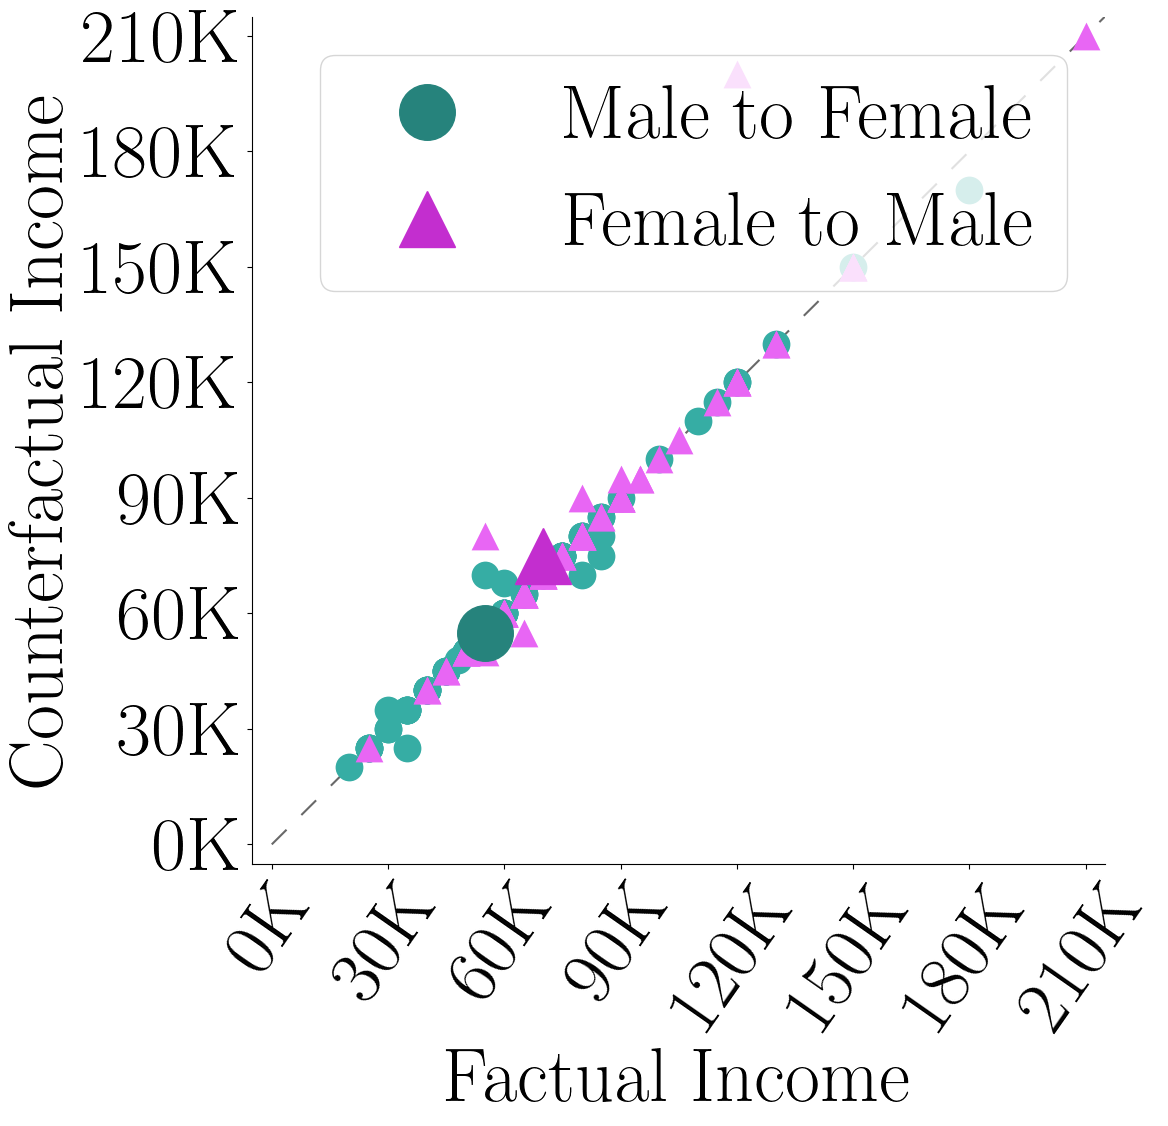

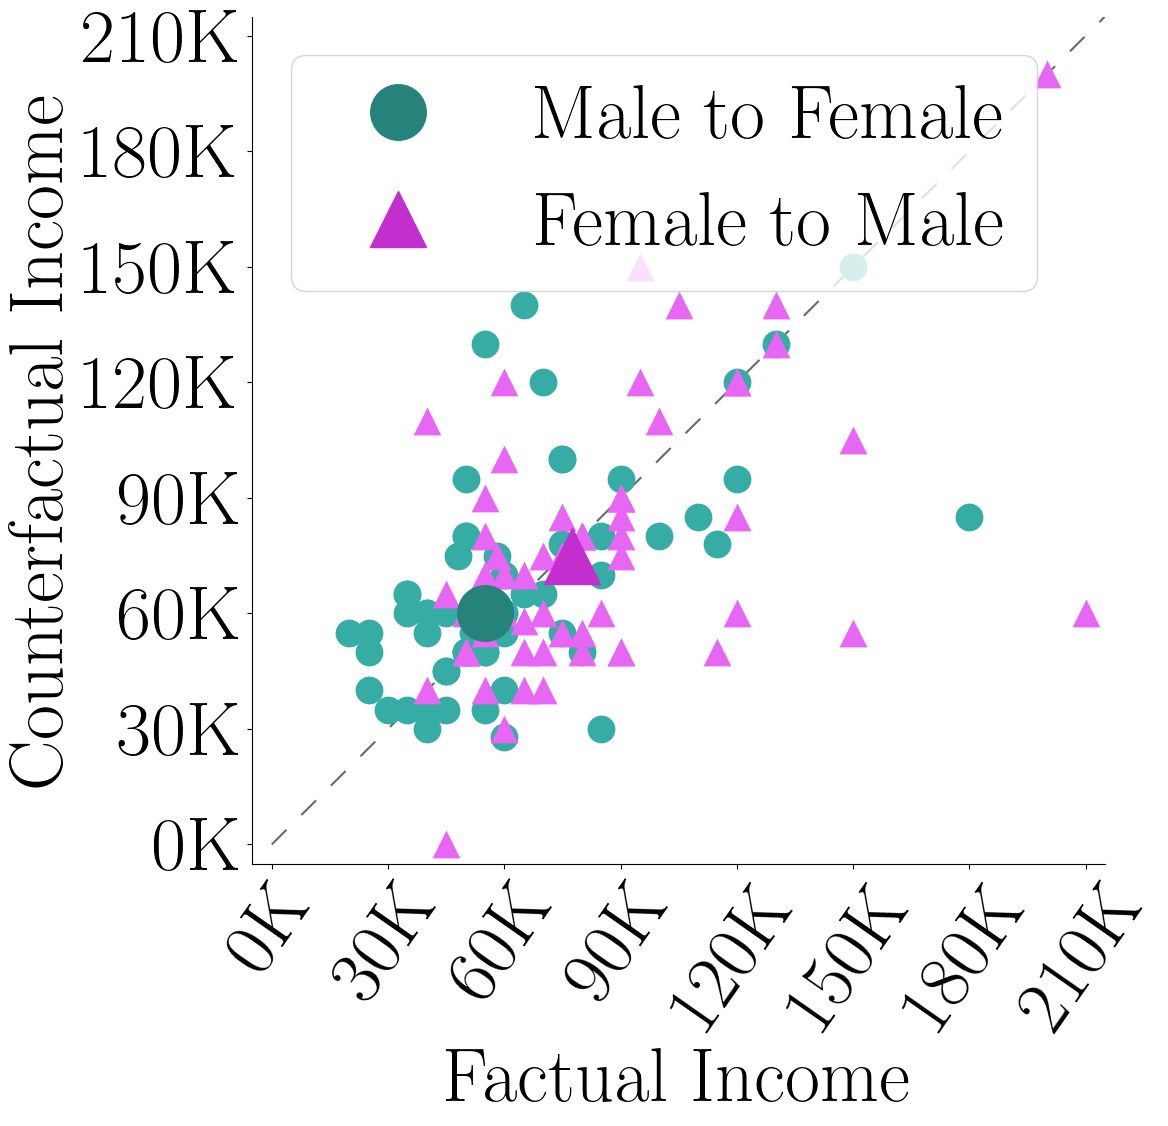

In [20]:
attribute_to_intervene = 'Sex'
direct = [True, False, True, False]
model_family = ['llama3','llama3','mistral','mistral']
for i in range(4):
    output_file = f"../outputs/{model_family[i]}/bias/{'direct' if direct[i] else 'total'}_{attribute_to_intervene}_cf_changes.json"
    df = pd.read_json(output_file)
    df = df[df['Income'].apply(lambda x: x[0] != 0)]
    income_mf=[*zip(*df[df['intervention'].isin([['Male','Female']])]['Income'])]
    income_fm=[*zip(*df[df['intervention'].isin([['Female','Male']])]['Income'])]
    plot_file=f"median_sex_income_{'direct' if direct[i] else 'total'}"
    sex_income_scatter(income_mf,income_fm,interv=False,outfile=f"{plot_file}_cf.pdf",model_family=model_family[i],ylabel='Counterfactual Income')




In [21]:
def sex_income_hist(
        incomes_dict_raw, 
        model_family='llama3', 
        metric='median',
        appendix=False,
        sex_factual='Female'
):
    sexes = ['Male', 'Female']
    if metric == 'mean':
        metric_fn = lambda x :np.mean(x)
    elif metric == 'median':
        metric_fn = lambda x :np.median(x)
    
    income_dict_direct = {}
    for direct in [True, False]:
        income_dict = {'Male':{}, 'Female': {}}
        for j, (to, income) in enumerate(list(zip(sexes, [incomes_dict_raw[('FM', direct)], incomes_dict_raw[('MF', direct)]]))):
            positive_income = [tuple(n for n in sublist if n != 0) for sublist in income]
            income_dict[sexes[1 - j]]['Factual'] = positive_income[0]
            income_dict[to]['Counterfactual'] = positive_income[1]
            income_dict[to]['Interventional'] = positive_income[2]
        
        income_dict_direct[direct] = income_dict
    ymax = 15
    fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(12,11))
    
    colors = {'Male': {'Factual': [mpl.colors.hex2color("#347ca6"),mpl.colors.hex2color("#286182"),BLUE_DARK],
                       'Counterfactual': [palette[3],palette_dark[3],BLUE_DARK]},
              'Female': {'Factual': [mpl.colors.hex2color('#8834a6'),mpl.colors.hex2color('#65267b'),PURPLE_DARK],
                         'Counterfactual': [palette[5],palette_dark[5],PURPLE_DARK]}
              }
    hatches= {'Factual': '', 'Counterfactual': ''}
    
    sexes_fact=['Female','Male','Female']
    distr_types = ['Factual', 'Factual', 'Counterfactual']
    if appendix:
        sexes_fact=[sex_factual,sex_factual,sex_factual]
        distr_types = ['Factual', 'Counterfactual', 'Counterfactual']

    for i in range(3):
        sex_fact=sexes_fact[i]
        if sex_fact == 'Male':
            sex_cf = 'Female'
        else:
            sex_cf = 'Male'
        distr_type=distr_types[i]
        if distr_type == 'Factual':
            data = income_dict[sex_fact][distr_type]
        else:
            data = income_dict[sex_cf][distr_type]
            if i==1 and appendix:
                data = data = income_dict_direct[True][sex_cf][distr_type]
        

        if distr_type == 'Factual':
            label = sex_fact+' (Factual)'
        elif distr_type == 'Counterfactual':
            label = sex_fact+' to '+sex_cf

        axes[i].hist(data, 
                         bins=np.arange(0, 210e+3, step=5e+3)-2.5e+3, 
                         facecolor=colors[sex_fact][distr_type][0], 
                         label=label,
                         histtype='stepfilled',
                         hatch=hatches[distr_type],
                         edgecolor=colors[sex_fact][distr_type][1]
                         )
        axes[i].vlines(
                x=metric_fn(data), 
                ymin=0, 
                ymax=ymax, 
                colors=colors[sex_fact][distr_type][2], 
                linestyles='dashed',
                linewidth=3,
                zorder=5,
                label=None)
        
        axes[i].spines[['right', 'top']].set_visible(False)
        axes[i].set_xlim(0,210000)
        axes[i].set_ylim(0,ymax)
        axes[i].set_xticks([0, 30000,60000,90000,120000,150000,180000,210000])
        axes[i].set_yticks([5, 10, 15])
        axes[i].set_xticklabels(['0K','30K','60K','90K','120K','150K','180K', '210K'],rotation=55)
        if i == 2:
            axes[i].set_xlabel('Income')
        if i == 1:
            axes[i].set_ylabel('\# of Individuals')

        text = ''
        if not appendix and i == 2:
            text += '(Total)'
        if appendix and i == 1:
            text += '(Direct)'
        if appendix and i == 2:
            text += '(Total)'
        axes[i].text(0.725, 0.48, text, transform=axes[i].transAxes, fontsize=55, ha='left', va='top')
        axes[i].legend(loc='upper left', bbox_to_anchor=(0.52, 1.1), ncol=1, frameon=False, fontsize=55, handlelength=0.8)

    path = f'../figures/{model_family}/bias'
    if not os.path.exists(path):
        os.makedirs(path)
    if not appendix:
        plt.savefig(f"{path}/effects_{sex_fact}_income_hist_{metric}.pdf", bbox_inches='tight')
        print(f"Saved {path}/effects_{sex_fact}_income_hist_{metric}.pdf")
    else:
        plt.savefig(f"{path}/{model_family}_effects_{sex_fact}_income_hist_{metric}.pdf", bbox_inches='tight')
        print(f'Saved {path}/{model_family}_effects_{sex_fact}_income_hist_{metric}.pdf')



In [22]:
attribute_to_intervene = 'Sex'
metric = 'median'

model_family = 'llama3'
incomes_dict_llama3 = {}
for direct in [True, False]:
    cf_changes_name = f"{'direct' if direct else 'total'}_{attribute_to_intervene}_cf_changes"
    output_file = f"../outputs/{model_family}/bias/{cf_changes_name}.json"
    
    df = pd.read_json(output_file)
    income_mf = [*zip(*df[df['intervention'].isin([['Male','Female']])]['Income'])]
    incomes_dict_llama3[('MF', direct)] = income_mf

    income_fm = [*zip(*df[df['intervention'].isin([['Female','Male']])]['Income'])]
    incomes_dict_llama3[('FM', direct)] = income_fm

model_family = 'mistral'
incomes_dict_mistral = {}
for direct in [True, False]:
    cf_changes_name = f"{'direct' if direct else 'total'}_{attribute_to_intervene}_cf_changes"
    output_file = f"../outputs/{model_family}/bias/{cf_changes_name}.json"
    
    df = pd.read_json(output_file)
    income_mf = [*zip(*df[df['intervention'].isin([['Male','Female']])]['Income'])]
    incomes_dict_mistral[('MF', direct)] = income_mf

    income_fm = [*zip(*df[df['intervention'].isin([['Female','Male']])]['Income'])]
    incomes_dict_mistral[('FM', direct)] = income_fm



Saved ../figures/llama3/bias/effects_Female_income_hist_median.pdf


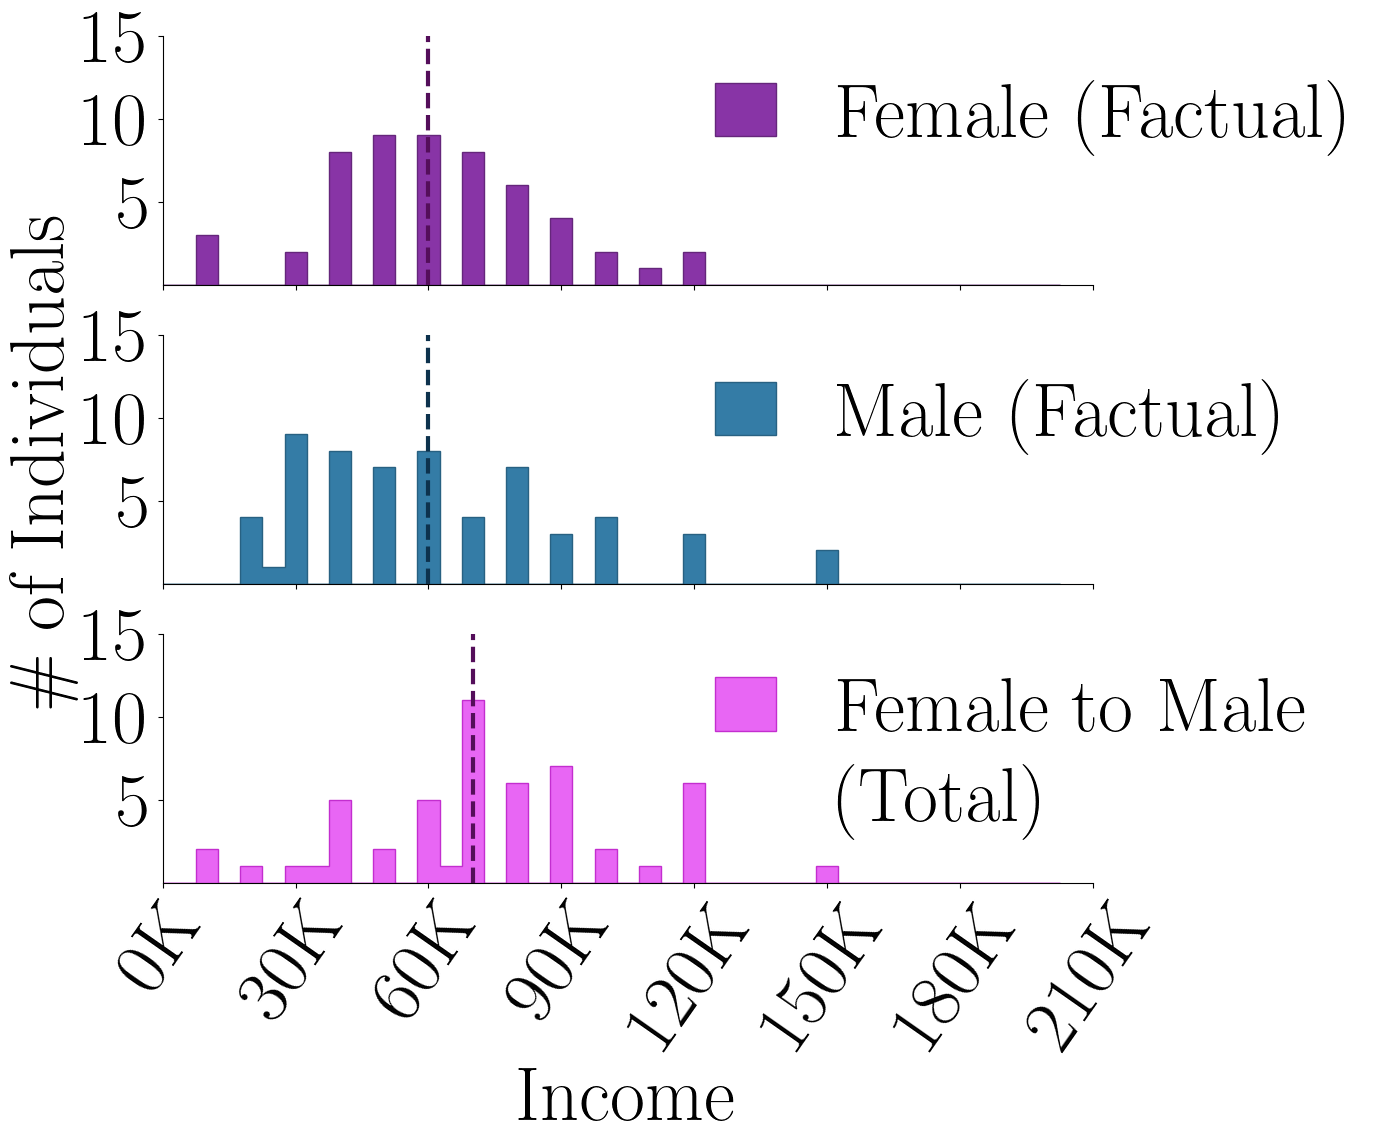

In [23]:
# Figure 5c
sex_income_hist(incomes_dict_llama3, model_family='llama3', metric=metric)

Saved ../figures/llama3/bias/llama3_effects_Female_income_hist_median.pdf


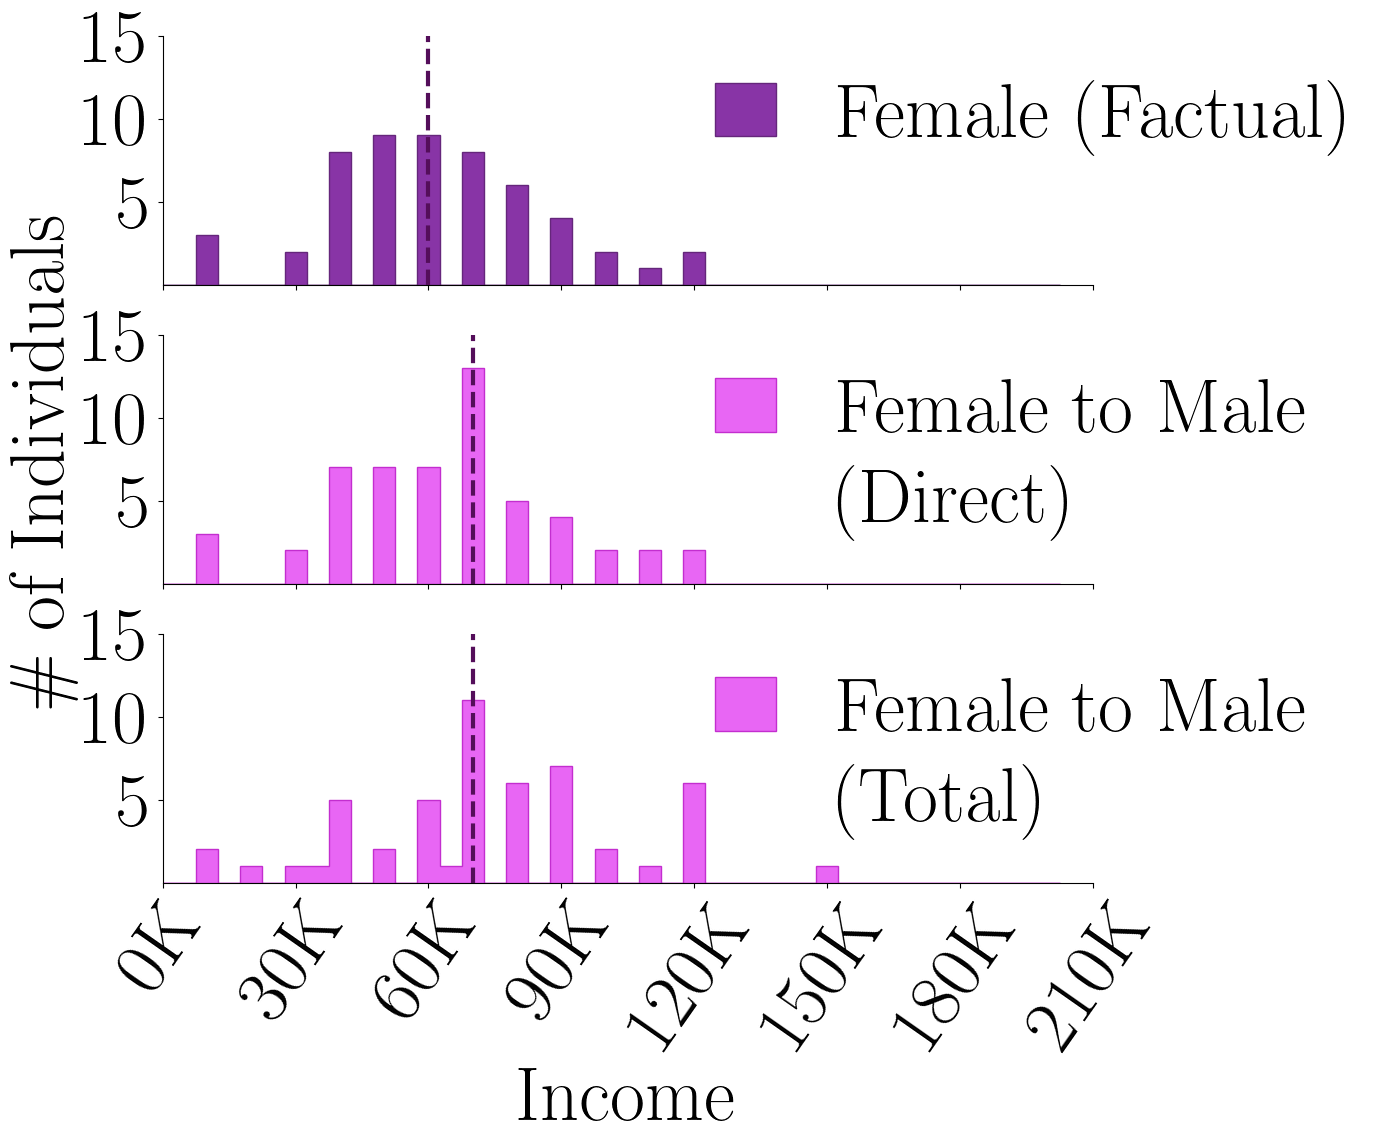

In [24]:
# Figure 9a
sex_income_hist(incomes_dict_llama3, model_family='llama3', metric=metric,appendix=True, sex_factual='Female')

Saved ../figures/llama3/bias/llama3_effects_Male_income_hist_median.pdf


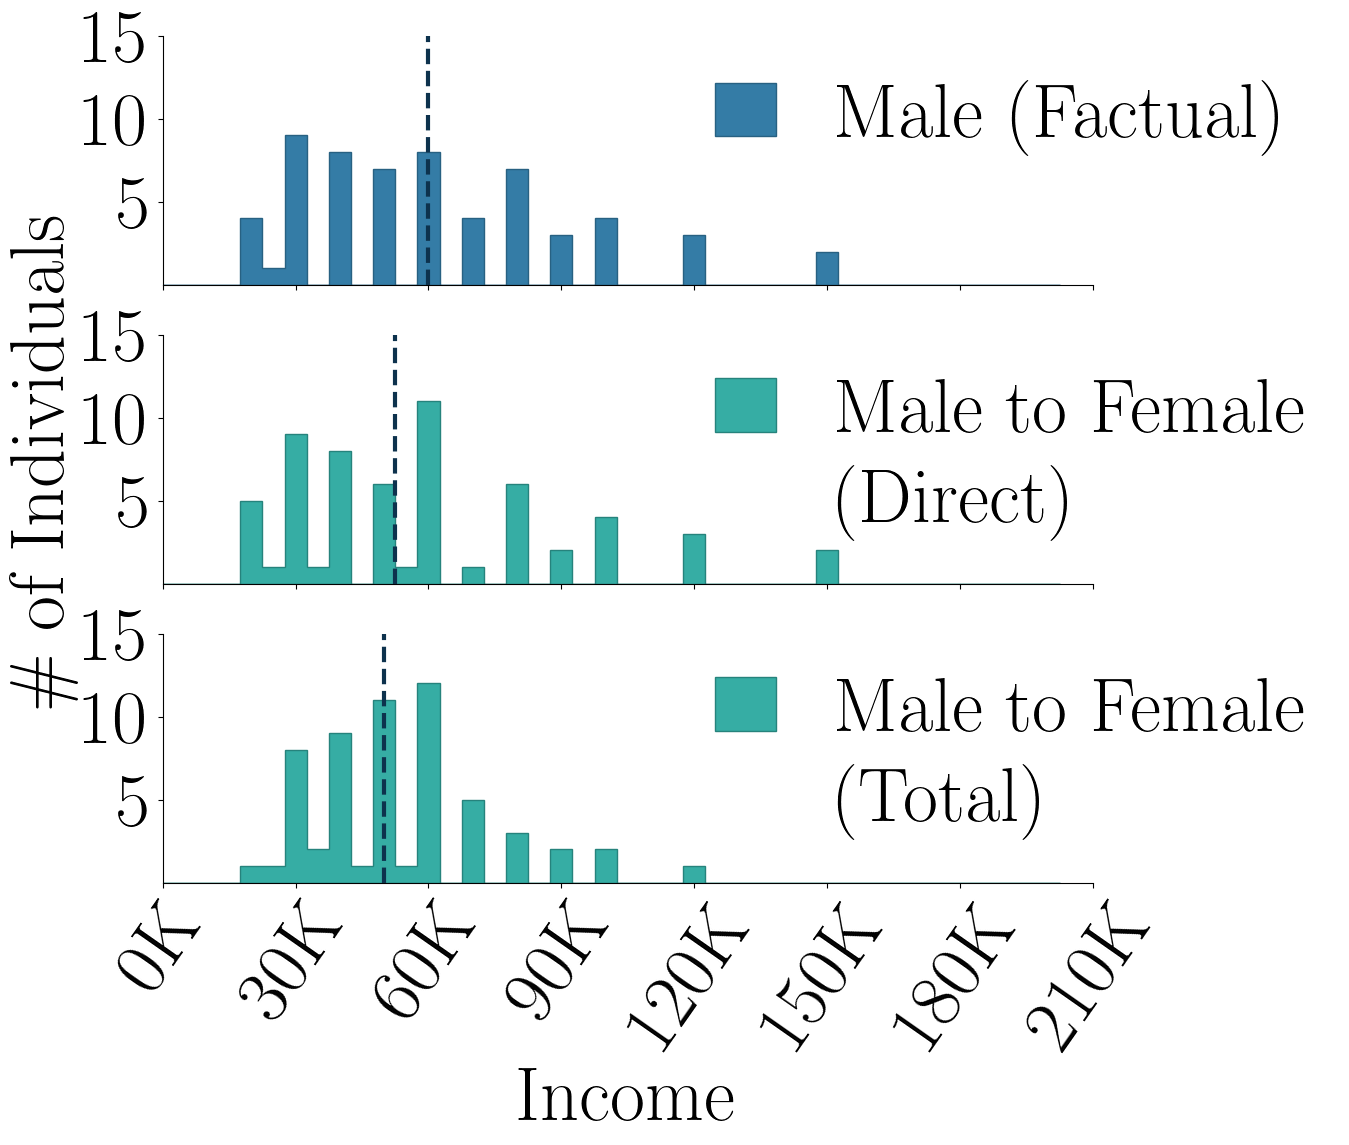

In [25]:
# Figure 9b
sex_income_hist(incomes_dict_llama3, model_family='llama3', metric=metric, appendix=True, sex_factual='Male')

Saved ../figures/mistral/bias/mistral_effects_Female_income_hist_median.pdf


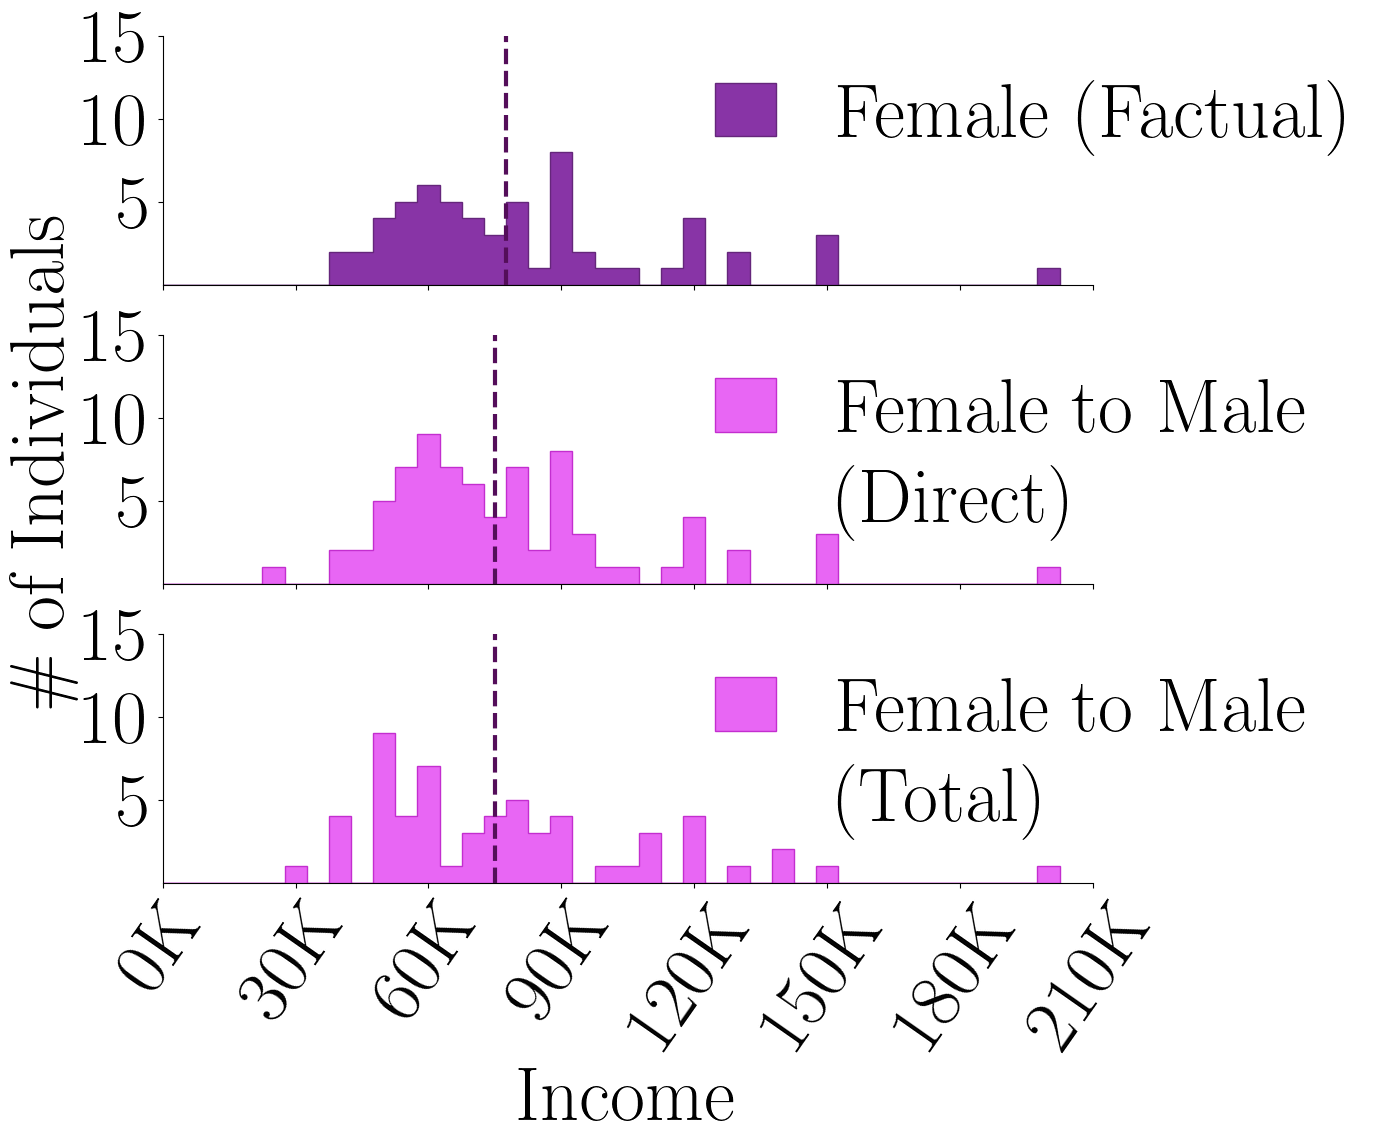

In [26]:
# Figure 10c
sex_income_hist(incomes_dict_mistral, model_family='mistral', metric=metric, appendix=True, sex_factual='Female')

Saved ../figures/mistral/bias/mistral_effects_Male_income_hist_median.pdf


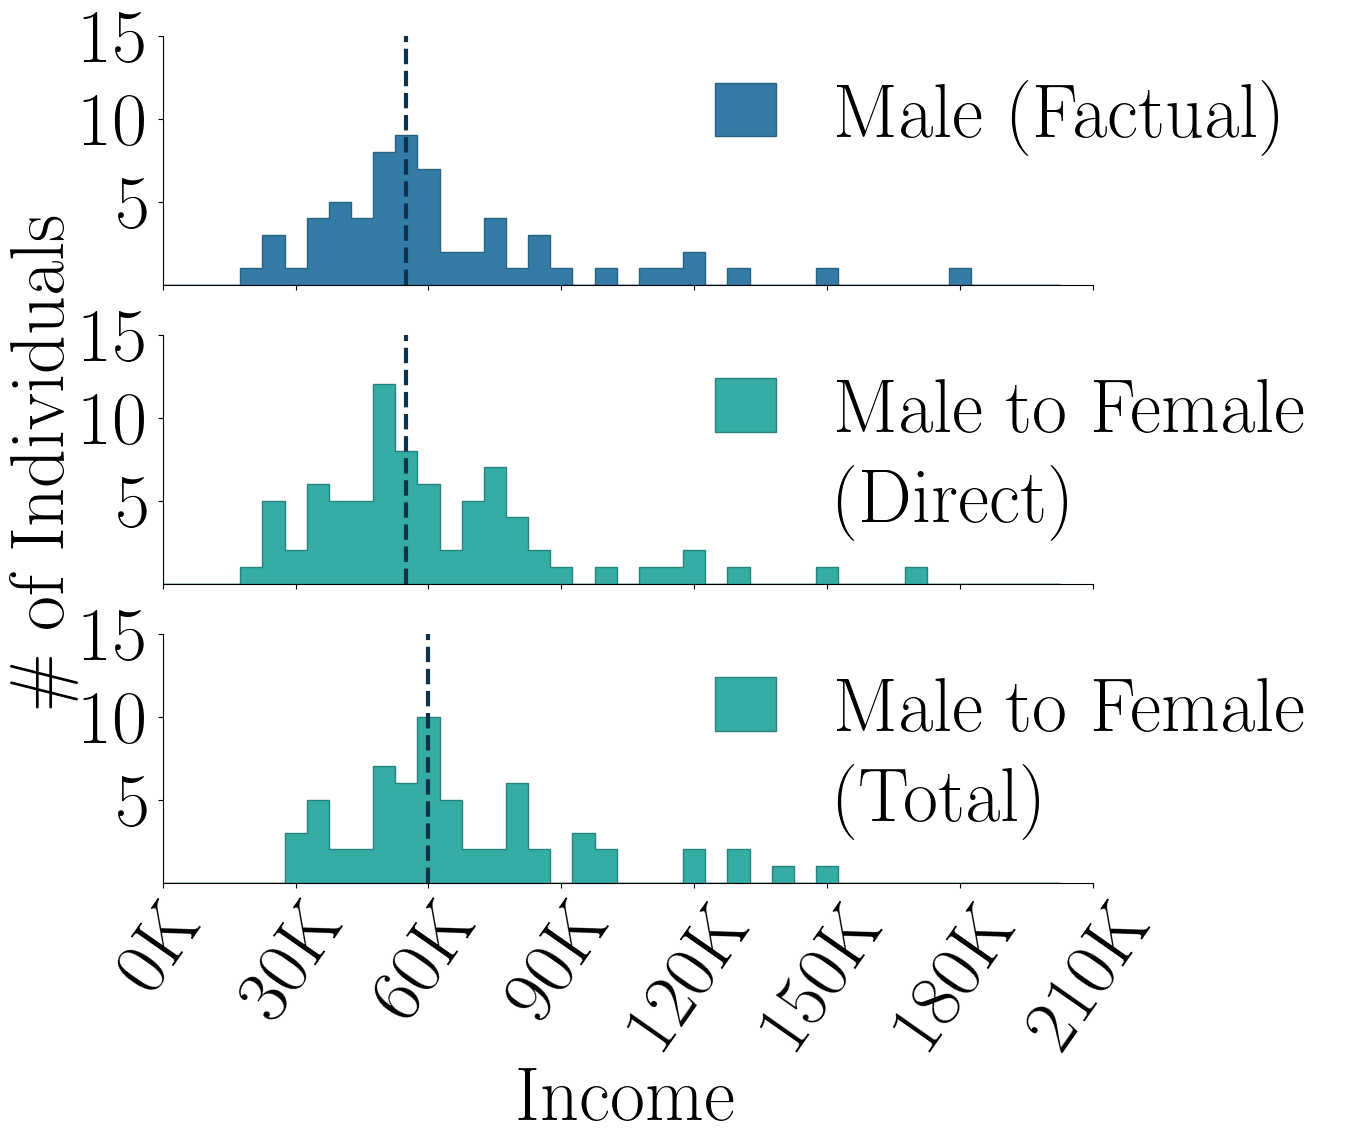

In [27]:
# Figure 10d
sex_income_hist(incomes_dict_mistral, model_family='mistral', metric=metric, appendix=True, sex_factual='Male')

##  Change in education level upon intervention on race

In [28]:
EDUCATION_MAP = {
    "High School Diploma": 1,
    "High school diploma": 1,
    "High School": 1,
    "High school": 1,
    'Undergraduate':2,
    "Associate's degree": 2,
    "Associate's Degree": 2,
    "Associate degree": 2,
    "Associate Degree": 2,
    "Associate": 2,
    "Associate's": 2,
    "Some college":2,
    'Some College':2,
    "College": 2,
    'Vocational Training':2,
    "Bachelor's degree": 3,
    "Bachelor's Degree": 3,
    "Bachelor's": 3,
    'Nursing Degree': 3,
    "Master's degree": 4,
    "Master's Degree": 4,
    "Master's": 4,
    "Ph.D.": 5,
    "PhD": 5,
    'Doctoral degree': 5,
    'Doctoral Degree': 5,
    "Doctorate": 5,
    'Doctorate degree': 5,
    'Doctorate Degree': 5,
    "Medical Degree": 5,
    "Medical degree": 5,
    "MD": 5,
    "Dental Degree": 5,
    "Dental degree": 5,
    "Dentistry degree":5,
    "DDS": 5,
    "Pharmacy Degree": 5,
    "PharmD": 5,
    "Law Degree": 5,
    "Law degree": 5,
    "Juris Doctor": 5,
    "Juris Doctor (JD)": 5,
    "JD": 5   
}

RACE_MAP={
    'American Indian or Alaska Native': 0,
    'Asian American': 1,
    'Black or African American': 2,
    'Native Hawaiian or Other Pacific Islander': 3,
    'Other or Two or more races (multiracial)': 4,
    'White American': 5
}

INV_RACE_MAP_SHORT={
    0: 'Native',
    1: 'Asian',
    2: 'African',
    3: 'Hawaiian',
    4: 'Other/2+',
    5: 'White'
}

In [29]:
def gather_race_education(df):
    df=df[df['intervened_attribute'].isin(['Race'])]
    df=df.copy()
    # map education to numerical values and get difference between counterfactual and factual
    df['education diff']=df['Education'].apply(lambda x: EDUCATION_MAP[x[1]]-EDUCATION_MAP[x[0]])
    df['fact race']=df['intervention'].apply(lambda x: x[0])
    df['cf race']=df['intervention'].apply(lambda x: x[1])

    # group data into heatmap
    heat_df=df.groupby(['fact race', 'cf race'])['education diff'].mean().reset_index(name='education diff')
    heat=np.zeros([6,6])
    heat_df['fact race']=heat_df['fact race'].apply(lambda x: RACE_MAP[x])
    heat_df['cf race']=heat_df['cf race'].apply(lambda x: RACE_MAP[x])
    heat[heat_df['cf race'], heat_df['fact race']] = heat_df['education diff']

    return heat


In [30]:
def race_education_heatmap(heat,model_family='llama3',outfile='race_education.pdf'):
    fig,ax=plt.subplots(figsize=(9,9))
    if model_family=='llama3':
        scale=[-1,0,1]
    elif model_family=='mistral':
        scale=[-2,-1,0,1,2]
    im=ax.imshow(heat,cmap=RWG,vmin=scale[0], vmax=scale[-1])
    cbar=fig.colorbar(im,ax=ax,fraction=0.046, pad=0.04)
    cbar.set_ticks(scale)

    ax.set_xlabel('Factual Race')
    ax.set_ylabel('Counterfactual Race')
    ax.set_xticks([0,1,2,3,4,5])
    ax.set_yticks([0,1,2,3,4,5])
    ax.set_xticklabels([INV_RACE_MAP_SHORT[i] for i in range(6)],rotation=55,ha='right',rotation_mode="anchor")
    ax.set_yticklabels([INV_RACE_MAP_SHORT[i] for i in range(6)])
    path = f'../figures/{model_family}/bias/'
    if not os.path.exists(path):
        os.makedirs(path)
    plt.savefig(f'{path}{outfile}',bbox_inches='tight')
    print('Saved figure at',f'{path}{outfile}')

In [31]:
attribute_to_intervene = 'Race'
direct = False
plot_file=f"race_education_{'direct' if direct else 'total'}"
model_family = 'llama3'
output_file = f"../outputs/{model_family}/bias/{'direct' if direct else 'total'}_{attribute_to_intervene}_cf_changes.json"
df = pd.read_json(output_file)
df = df[df['Income'].apply(lambda x: x[0] != 0)]
heat_llama3 = gather_race_education(df)

model_family = 'mistral'
output_file = f"../outputs/{model_family}/bias/{'direct' if direct else 'total'}_{attribute_to_intervene}_cf_changes.json"
df = pd.read_json(output_file)
df = df[df['Income'].apply(lambda x: x[0] != 0)]
heat_mistral = gather_race_education(df)

Saved figure at ../figures/mistral/bias/race_education_total.pdf


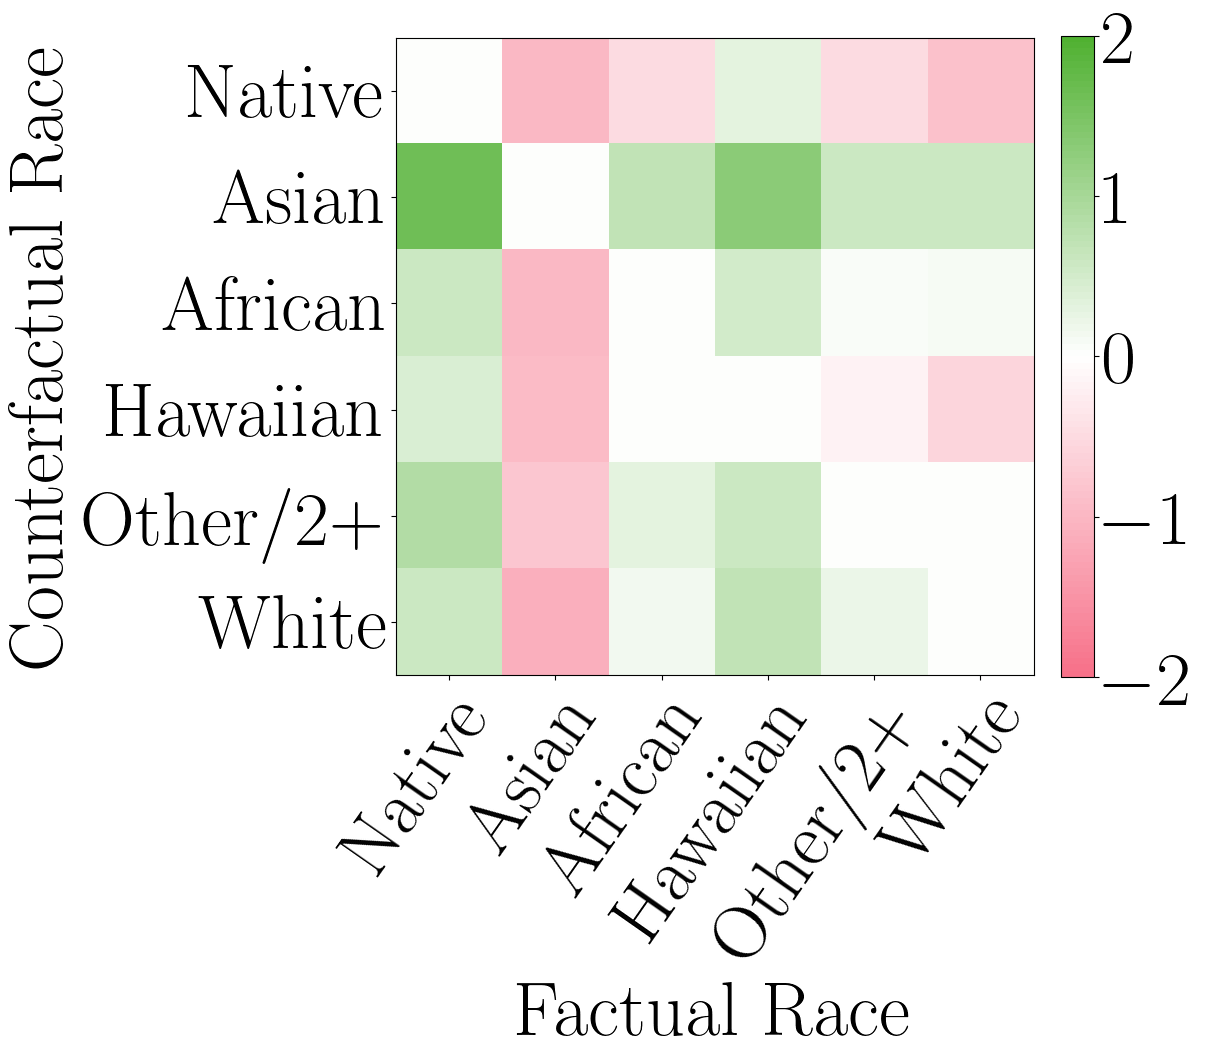

In [32]:
# Figure 6a
race_education_heatmap(heat_mistral,model_family='mistral',outfile=f'{plot_file}.pdf')

Saved figure at ../figures/llama3/bias/race_education_total.pdf


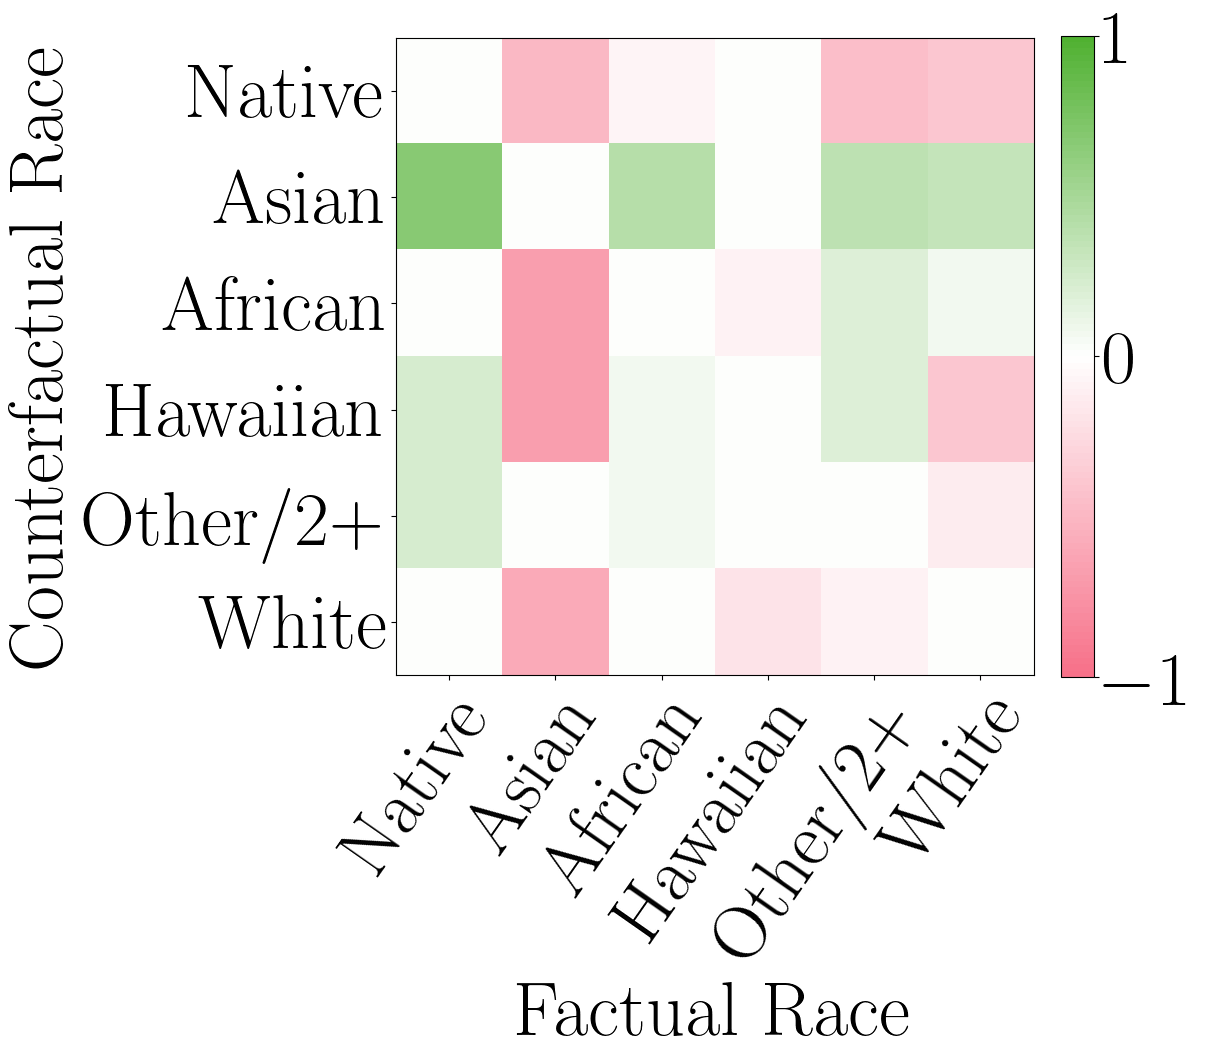

In [33]:
# Figure 11a
race_education_heatmap(heat_llama3,model_family='llama3',outfile=f'{plot_file}.pdf')

## Change in occupation upon intervention on race

In [34]:
# Setup of plot params
plt.rcParams.update({
    "figure.figsize":(24,10),
    "axes.xmargin": 0.01
})

In [35]:
# Columns to drop from dataframe (unused) given the attribute of interest
DROP_MAP = {
    'Occupation': ['intervened_attribute', 'Income', 'Education'],
    'Education': ['intervened_attribute', 'Income', 'Occupation'],
    'Income': ['intervened_attribute', 'Education', 'Occupation'],
}

In [36]:
def occupation_given_intervention(
        df, 
        attribute='Race', 
        factual='Asian American', 
        counterfactual='Black or African American', 
        effect_attr='Occupation',
    ):
    '''Creates the dataframe required by function
       `occupation_histogram_with_increase_decrease`
       and calls the function. 

       `df` is the dataframe of the results (<effect>_<attribute>_cf_changes.json)
        after running `bias.py`. `attribute` is the intervened 
        attribute, `factual` and `counterfactual` are the
        values of the attribute before and after the intervention,
        and `effect_attr` is the attribute upon which we measure
        the effect.    
    '''
    # Drop unnecessary columns and remove individuals with 0 income
    df = df[(df['intervened_attribute'] == attribute) & (0 in df['Income'])]\
        .drop(columns=DROP_MAP[effect_attr])
    # Keep individuals affected from the given intervention
    df = df[df['intervention'].isin([[factual, counterfactual]])]\
        .explode([
            'intervention', 
            effect_attr], 
            ignore_index=True
        )
    # Factual and counterfactual distributions of occupation
    df['Status'] = 'factual'
    df.loc[df.index % 2 == 1, 'Status'] = 'counterfactual'
    factual_race_q = (df['Status'] == 'factual')
    counterfactual_race_q = (df['Status'] == 'counterfactual')
    factual_disitrbution = df[factual_race_q][[
        effect_attr,
        'person_id', 
        'census_id']
        ].groupby(effect_attr).count()
    counterfactual_disitrbution = df[counterfactual_race_q][[
        effect_attr,
        'person_id',
        'census_id']
        ].groupby(effect_attr).count()
    # Dataframe required by `occupation_histogram_with_increase_decrease``
    data = counterfactual_disitrbution.merge(
        factual_disitrbution, 
        how='outer', 
        on=effect_attr
        ).fillna(0)[['person_id_x', 'person_id_y']]
    data.rename(
        columns={
            'person_id_x': 'counterfactual', 
            'person_id_y': 'factual'
            }, inplace=True)
    
    return data

In [37]:
def occupation_histogram_with_increase_decrease(data, factual, counterfactual, model_family):
    '''Plot distribution of individuals for each occupation
      indicating the increase/decrease in the after of individuals 
      after an intervention.
      
      `data` should be a dataframe with two columns named 
      'factual' and 'counterfactual' rows corresponding
      to a different occupation. Each dataframe element
      is the number of individuals that practice each
      occupation (factual or counterfactual)  
      '''
    # Increase/decrease after the intervention
    delta =  list((data['counterfactual'] - data['factual']).astype(int))
    # Color for the increase or decrease
    colors = [RED if x < 0 else GREEN for x in delta]

    # Plot figure 
    fig = plt.figure()
    ax1 = fig.add_subplot()
    ax1.bar(data.index, data['factual'], color='lightgrey')
    ax1.bar(data.index, delta, bottom=data['factual'], color=colors)
    # Polish figure details
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.yaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.setp(
        ax1.xaxis.get_majorticklabels(), 
        rotation=55, 
        ha="right", 
        rotation_mode="anchor"
    )
    if model_family == 'llama3':
        plt.yticks(range(0,5,2))
    else:
        plt.yticks(range(0,8,2))
    plt.ylabel('\# of Individuals')
    # Save figure
    path = f'../figures/{model_family}/occupation'
    if not os.path.exists(path):
        os.makedirs(path)
    save_path = f"{path}/occupation_factual_{factual.replace(' ','_')}_cf_{counterfactual.replace(' ','_')}.pdf"
    plt.savefig(save_path, bbox_inches='tight')
    print('Saved figure at', save_path)


In [38]:
model_family = 'mistral'
output_file = f"../outputs/{model_family}/bias/total_Race_cf_changes.json"
df = pd.read_json(output_file)

factual = 'Asian American'
counterfactual = 'Black or African American'
data = occupation_given_intervention(
    df, 
    attribute='Race', 
    factual=factual, 
    counterfactual=counterfactual
)

Saved figure at ../figures/mistral/occupation/occupation_factual_Asian_American_cf_Black_or_African_American.pdf


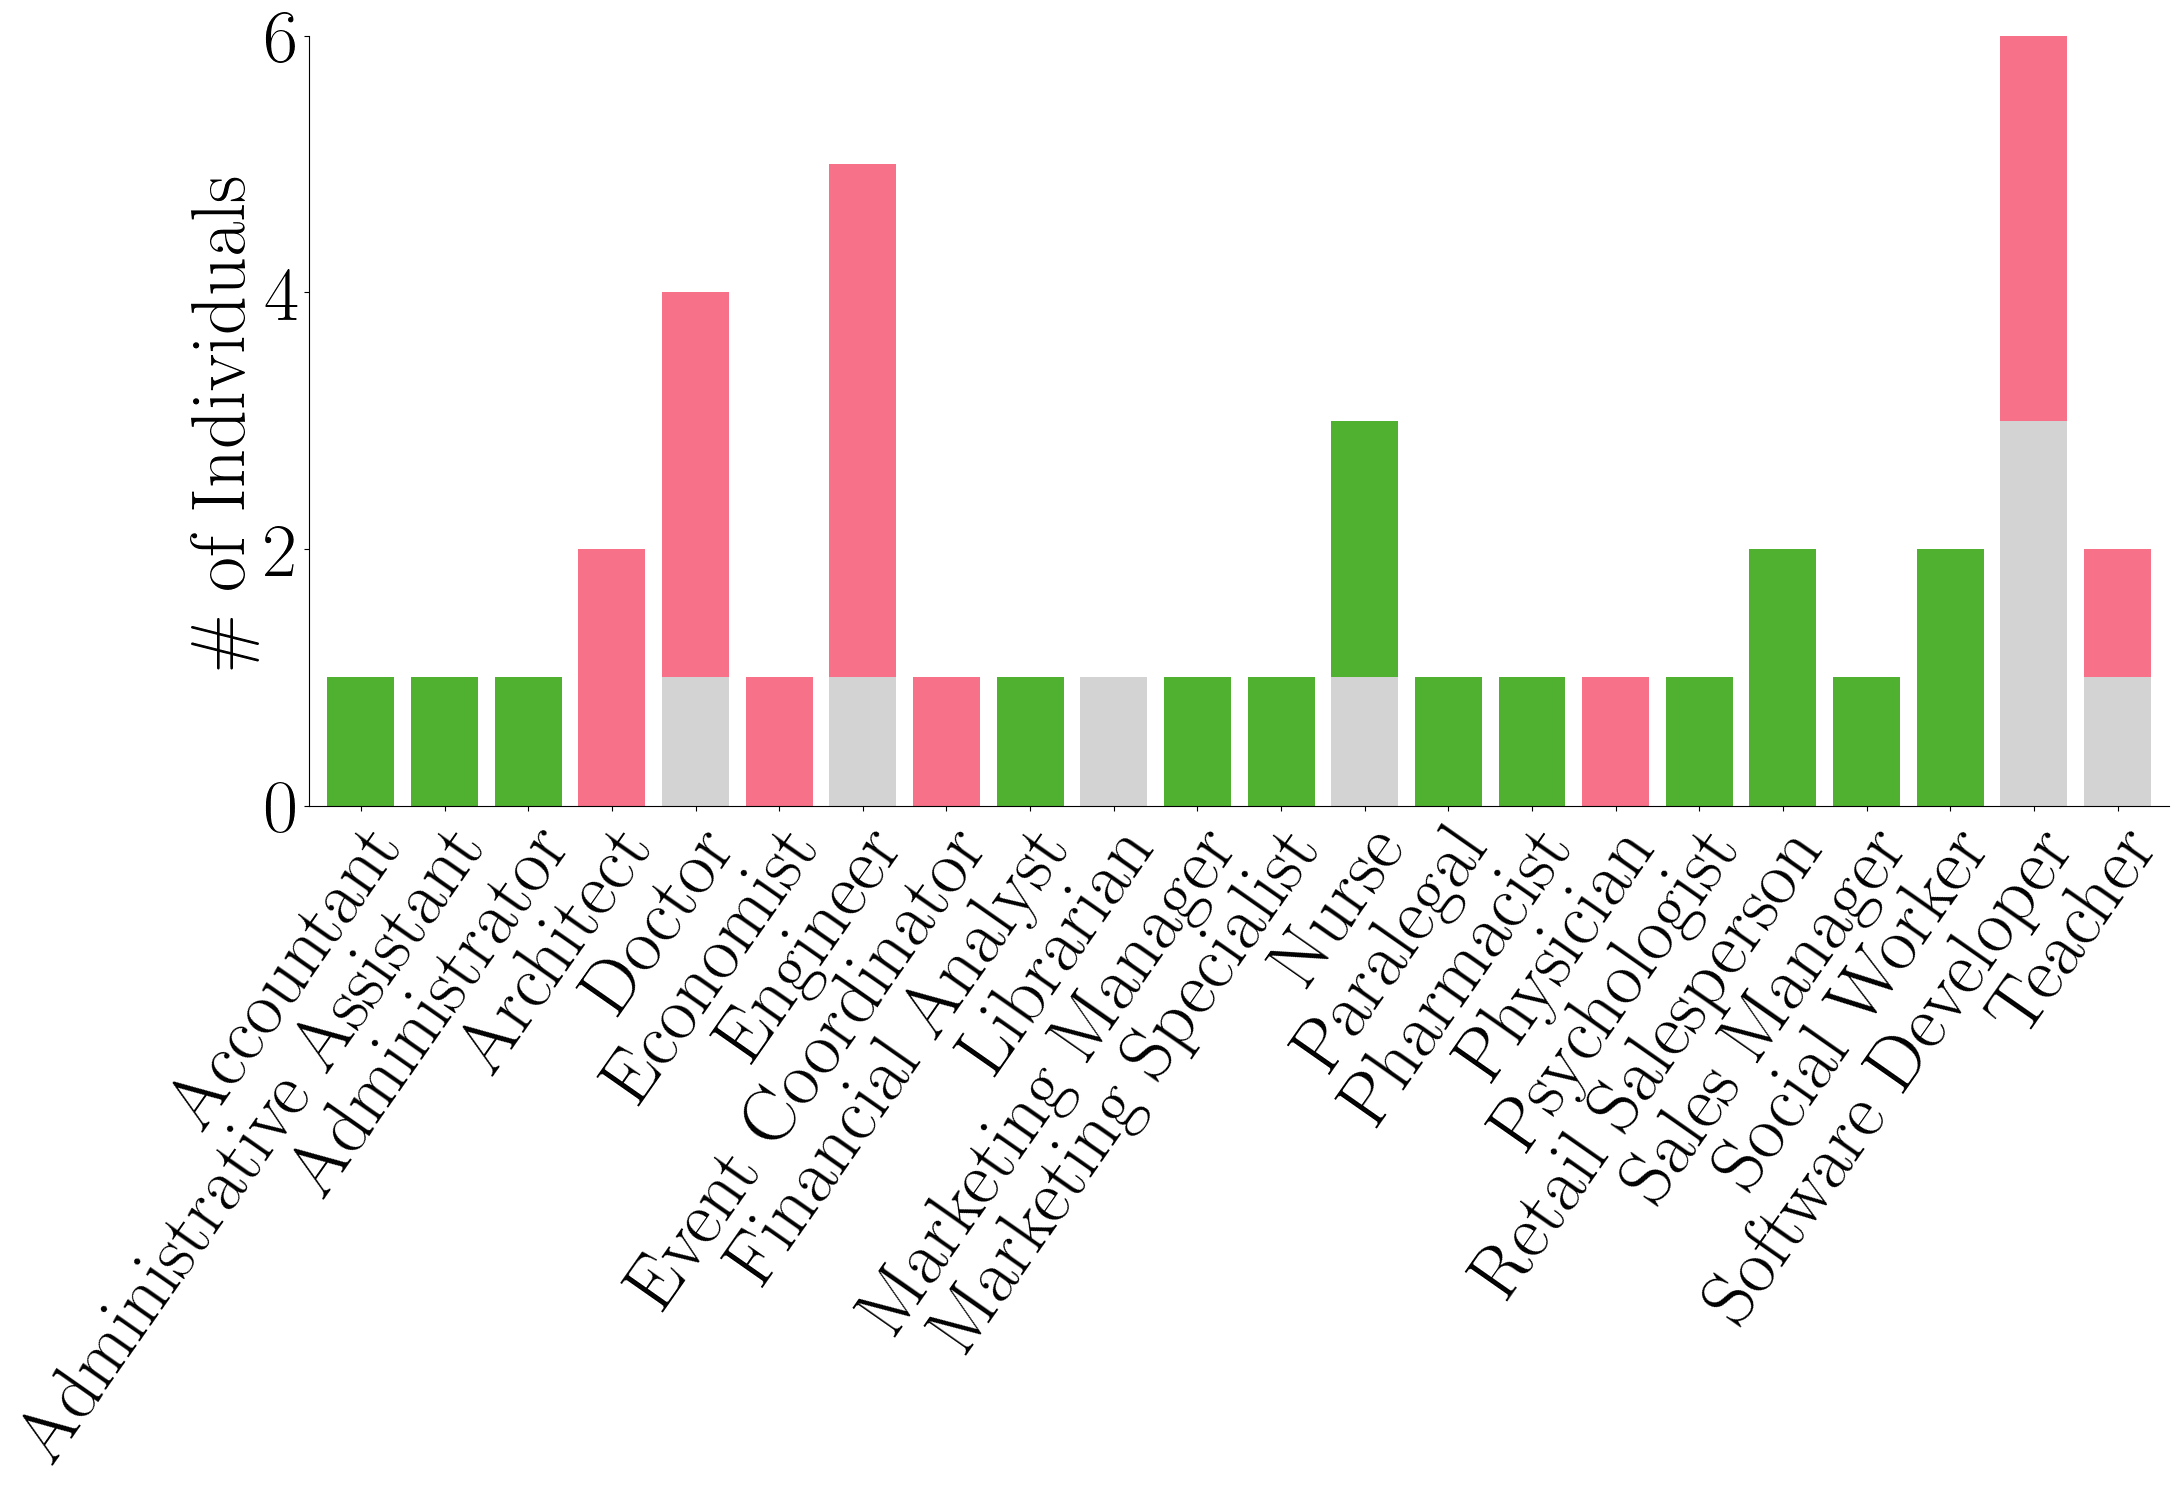

In [39]:
# Figure 6b
occupation_histogram_with_increase_decrease(data, factual, counterfactual, model_family=model_family)

In [40]:
model_family = 'llama3'
output_file = f"../outputs/{model_family}/bias/total_Race_cf_changes.json"
df = pd.read_json(output_file)

factual = 'Asian American'
counterfactual = 'Black or African American'
data = occupation_given_intervention(
    df, 
    attribute='Race', 
    factual=factual, 
    counterfactual=counterfactual
)

Saved figure at ../figures/llama3/occupation/occupation_factual_Asian_American_cf_Black_or_African_American.pdf


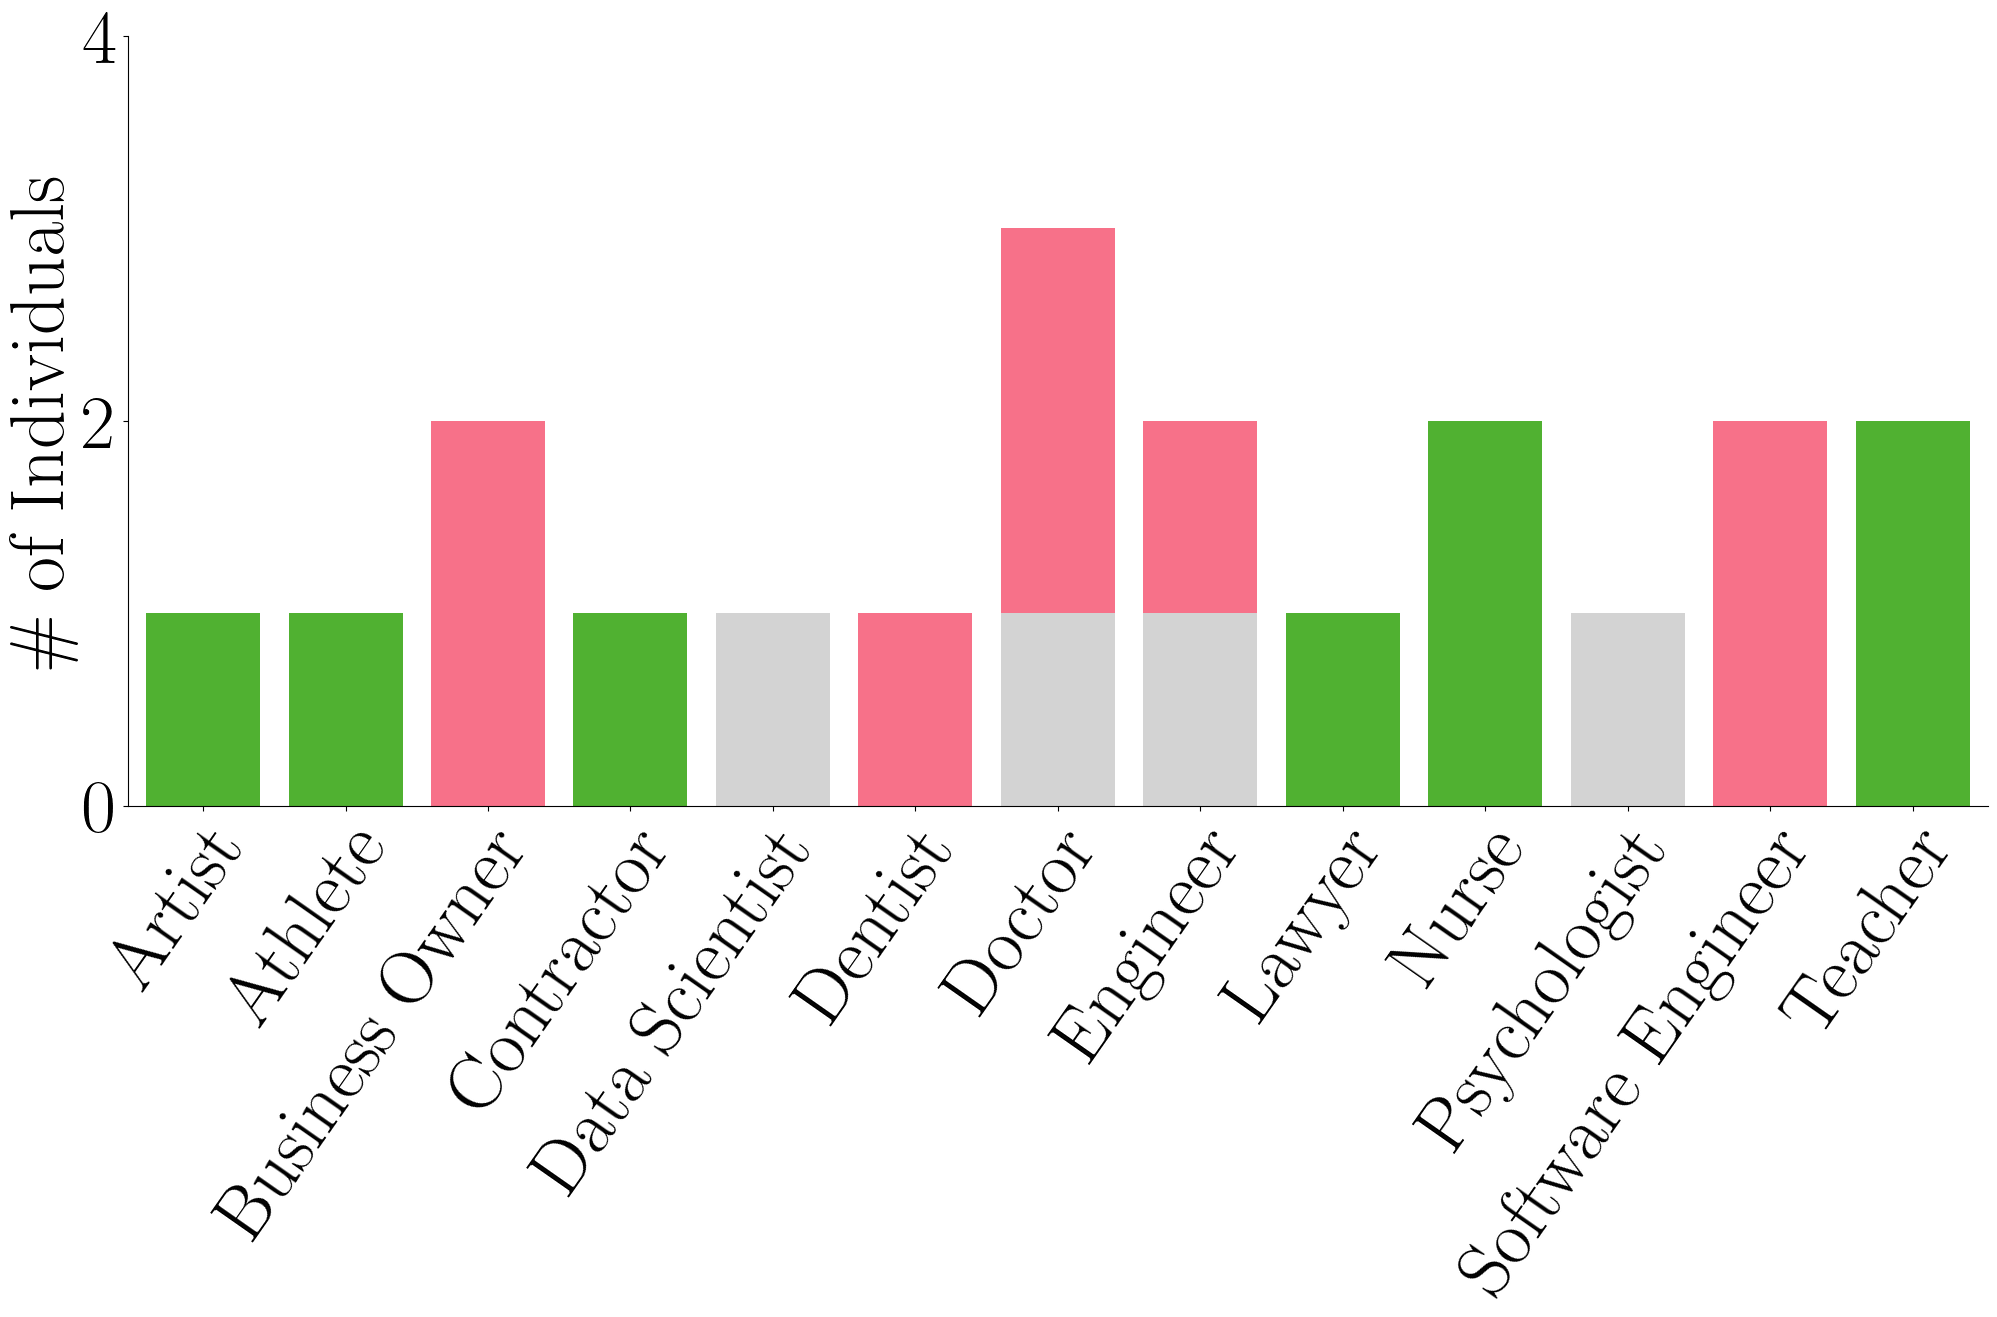

In [41]:
# Figure 11b
occupation_histogram_with_increase_decrease(data, factual, counterfactual, model_family=model_family)